In [5]:
from collections import defaultdict
import math
import os
from re import sub

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d
import torch
import torch.nn.functional as F
import tqdm

# Our new algorithm
from online_conformal.magnitude_learner import MagnitudeLearner, MagnitudeLearnerV2
from online_conformal.mag_learner_undiscounted import MagLearnUndiscounted
from online_conformal.ogd_simple import SimpleOGD

# From previous work
from online_conformal.saocp import SAOCP
from online_conformal.faci import FACI, FACI_S
from online_conformal.nex_conformal import NExConformal
from online_conformal.ogd import ScaleFreeOGD
from online_conformal.split_conformal import SplitConformal
from online_conformal.utils import pinball_loss
from cv_utils import create_model, data_loader
from cv_utils import ImageNet, TinyImageNet, CIFAR10, CIFAR100, ImageNetC, TinyImageNetC, CIFAR10C, CIFAR100C

from vision import *

Getting temp file...
Done
Load the saved logits
Initialize conformal prediction methods, along with accumulators for results


100%|██████████| 7050/7050 [00:04<00:00, 1558.43it/s]


Distribution shift: sudden
MagnitudeLearner: Avg Cov: 0.780, Avg Width: 93.2, LCEk: 0.20,Runtime:
MagLearnUndiscounted: Avg Cov: 0.894, Avg Width: 122.1, LCEk: 0.09,Runtime:
MagnitudeLearnerV2: Avg Cov: 0.861, Avg Width: 117.6, LCEk: 0.12,Runtime:


100%|██████████| 7050/7050 [00:04<00:00, 1623.04it/s]


Distribution shift: gradual
MagnitudeLearner: Avg Cov: 0.761, Avg Width: 129.0, LCEk: 0.20,Runtime:
MagLearnUndiscounted: Avg Cov: 0.896, Avg Width: 158.7, LCEk: 0.10,Runtime:
MagnitudeLearnerV2: Avg Cov: 0.860, Avg Width: 150.3, LCEk: 0.11,Runtime:


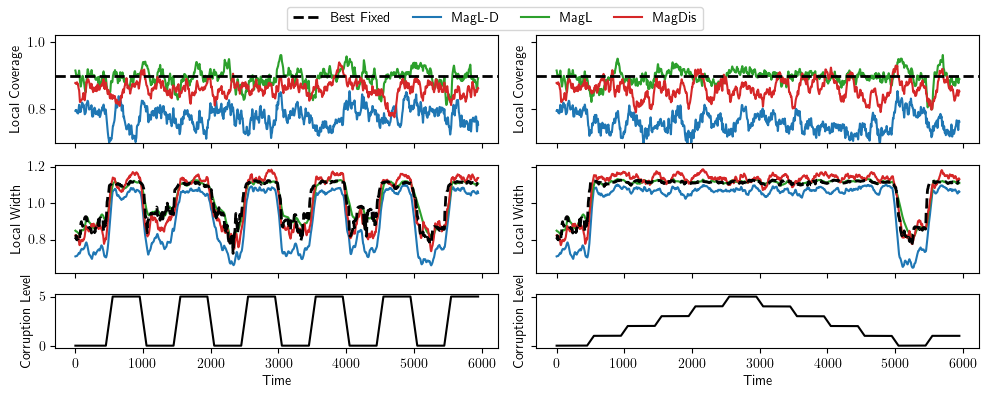

In [6]:

args = parse_args()
if not finished(args) and args.dataset != "ImageNet":
    print("Training models")
    train(args)
    print("Finished training")
if args.local_rank in [-1, 0]:
    print("Getting temp file...")
    temp_file = get_temp_file(args)
    print("Done")
    if not finished(args):
        print("get_logits(args)")
        get_logits(args)
        print("...Done")
        temp = temperature_scaling(args)
        with open(temp_file, "w") as f:
            f.write(str(temp))

    # Load the saved logits
    print("Load the saved logits")
    with open(temp_file) as f:
        temp = float(f.readline())
    n_data = None
    sev2results = defaultdict(list)
    for corruption in corruptions:
        severities = [0] if corruption is None else [1, 2, 3, 4, 5]
        for severity in severities:
            try:
                logits, labels = torch.load(get_results_file(args, corruption, severity))
            except:
                continue
            sev2results[severity].append(list(zip(F.softmax(logits / temp, dim=-1).numpy(), labels.numpy())))
            n_data = len(labels) if n_data is None else min(n_data, len(labels))

    # Initialize conformal prediction methods, along with accumulators for results
    print("Initialize conformal prediction methods, along with accumulators for results")
    lmbda, k_reg, n_class = raps_params(args.dataset)
    D_old = 1 + lmbda * np.sqrt(n_class - k_reg)
    D = D_old
    #methods = [SimpleOGD, ScaleFreeOGD, SAOCP, SplitConformal, NExConformal, FACI, FACI_S, MagnitudeLearner, MagLearnUndiscounted, MagnitudeLearnerV2]
    #methods = [MagnitudeLearner, MagLearnUndiscounted, MagnitudeLearnerV2]
    label2err = defaultdict(list)
    plt.rcParams["text.usetex"] = True
    h = 5 + 0.5 * (len(methods) > 5)
    fig, axs = plt.subplots(nrows=3, ncols=2, sharex="col", sharey="row", figsize=(10, h-1), height_ratios=[4, 4, 2])
    np.random.seed(0)
    for i_shift, shift in enumerate(["sudden", "gradual"]):
        sevs, s_opts, w_opts = [], [], []
        # warmup, window, run_length = 1000, 100, 500 # original code
        warmup, window, run_length = 1000, 100, 1000 # our code
        state = np.random.RandomState(0)
        order = state.permutation(n_data)[: 6 * run_length + window // 2 + warmup]
        coverages, s_hats, widths = [{m.__name__: [] for m in methods} for _ in range(3)]
        predictors = [m(None, None, max_scale = D, lifetime = 32, coverage = args.target_cov) for m in methods]
        t_vec = np.zeros(len(order))
        for t, i in tqdm.tqdm(enumerate(order, start=-warmup), total=len(order)):
            sev = t_to_sev(t, window=window, schedule = shift)
            probs, label = sev2results[sev][state.randint(0, len(sev2results[sev]))][i]

            # Convert probability to APS score
            i_sort = np.flip(np.argsort(probs))
            p_sort_cumsum = np.cumsum(probs[i_sort]) - state.rand() * probs[i_sort]
            s_sort_cumsum = p_sort_cumsum + lmbda * np.sqrt(np.cumsum([i > k_reg for i in range(n_class)]))
            w_opt = np.argsort(i_sort)[label] + 1
            s_opt = s_sort_cumsum[w_opt - 1]
            if t >= 0:
                sevs.append(sev)
                s_opts.append(s_opt)
                w_opts.append(w_opt)
                t_vec[t] = t

            # Update all the conformal predictors
            for predictor in predictors:
                name = type(predictor).__name__
                if t >= 0:
                    _, s_hat = predictor.predict(horizon=1)
                    w = np.sum(s_sort_cumsum <= s_hat)
                    s_hats[name].append(s_hat)
                    widths[name].append(w)
                    coverages[name].append(w >= w_opt)
                predictor.update(ground_truth=pd.Series([s_opt]), forecast=pd.Series([0]), horizon=1)

        # Perform evaluation & produce a pretty graph
        plot_loss = True
        for ax in axs[:, i_shift]:
            ax.xaxis.grid(False)
            ax.tick_params(axis="both", which="both", labelsize=10)

        #ax3, ax1, ax2 = axs[:, i_shift]
        ax1, ax2, ax3 = axs[:, i_shift]
        sevs = pd.Series(sevs).rolling(window).mean().dropna()
        w_opts = pd.Series(s_opts if plot_loss else w_opts).rolling(window).quantile(args.target_cov).dropna()
        ax1.set_ylabel("Local Coverage", fontsize=10)
        ax2.set_ylabel("Local Width", fontsize=10)
        ax3.set_xlabel("Time", fontsize=10)
        ax3.set_ylabel("Corruption Level", fontsize=10)
        ax1.axhline(args.target_cov, c="k", ls="--", lw=2, zorder=len(methods), label="Best Fixed")
        ax2.plot(np.arange(len(w_opts)), gaussian_filter1d(w_opts, sigma=2), c="k", ls="--", lw=2, zorder=len(methods)) # best fixed local width
        ax3.plot(np.arange(len(sevs)), sevs, c="k") # corruption level

        s_opts = np.asarray(s_opts)
        int_q = pd.Series(s_opts).rolling(window).quantile(args.target_cov).dropna()
        print(f"Distribution shift: {shift}")
        for i, m in enumerate(methods):
            # Compute various summary statistics
            name = m.__name__ # name of the method (OGD, SAOCP, etc.)
            label = sub("Split", "S", sub("Conformal", "CP", sub("ScaleFree", "SF-", sub("_", "-", name))))
            if name == "MagnitudeLearner":
                #label = "Mag. Learner ($\lambda_t < 1$)"
                label = "MagL-D"
            if name == "MagLearnUndiscounted":
                #label = "Mag. Learner ($\lambda_t = 1$)"
                label = "MagL"
            if name == "MagnitudeLearnerV2":
                #label = "Mag. Learner ($\lambda_t < 1, h_t = 0$)"
                label = "MagDis"
            s_hat = np.asarray(s_hats[name])
            int_cov = gaussian_filter1d(pd.Series(coverages[name]).rolling(window).mean().dropna(), sigma=3)
            int_w = pd.Series(s_hats[name] if plot_loss else widths[name]).rolling(window).mean().dropna()
            int_losses = pd.Series(pinball_loss(s_opts, s_hat, args.target_cov)).rolling(window).mean().dropna()
            opts = [pinball_loss(s_opts[i : i + window], q, args.target_cov).mean() for i, q in enumerate(int_q)]
            int_regret = int_losses.values - np.asarray(opts)
            int_miscov = np.abs(args.target_cov - int_cov)

            # Do the plotting
            color = "C" + str(i + (i > 0) if m is not SAOCP else 1)
            label2err[label].append(f"{np.max(int_miscov):.2f}")
            ax1.plot(range(len(int_cov)), int_cov, zorder=i, label=label, color=color) # local coverage
            ax2.plot(range(len(int_w)), gaussian_filter1d(int_w, sigma=2), zorder=i, label=label, color=color) # local width
            if min(int_cov) < args.target_cov - 0.2:
                ax1.set_ylim(args.target_cov - 0.2, 1.02)
            #
            print(
                f"{name:15}: "
                f"Avg Cov: {np.mean(coverages[name]):.3f}, "
                f"Avg Width: {np.mean(widths[name]):.1f}, "
                f"LCEk: {np.max(int_miscov):.2f},"
                f"Runtime:"
            )

    fig.tight_layout()
    labels = []
    lines = axs[0, 0].get_lines()
    for line in lines:
        label = line.get_label()
        if label in label2err:
            #label = f"{label}: $\\mathrm{{LCE}}_k = ({','.join(label2err[label])})$"
            label = f"{label}"
        labels.append(label)
    #ncols = math.ceil(len(lines) / 2) if FACI_S in methods else len(lines)
    ncols = 4
    fig.subplots_adjust(top=0.92 if ncols == len(lines) else 0.88)
    fig.legend(lines, labels, loc="upper center", ncols=ncols, fontsize=10, columnspacing=1.5)
    __file__ = "vision_TinyImageNet.ipynb"
    figdir = os.path.join(os.path.dirname(os.path.abspath(__file__)), "figures")
    os.makedirs(figdir, exist_ok=True)
    fig.savefig(os.path.join(figdir, f"{args.dataset}_{round(D/D_old,3)}D.pdf"))